In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase 
from matplotlib import colormaps as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import networkx as nx
import pyballmapper as pbm

from sklearn.preprocessing import MinMaxScaler

In [3]:
# Replace with your actual path if different
file_path = "/Users/alexander/Documents/MSc Data Science/erp-uom/data/dataErrors.csv"

# Load the CSV file
df = pd.read_csv(file_path)

In [5]:
# Columns you want to exclude from multiplication
exclude_cols = [
    'religious_fractionalization', 'ethnic_fractionalization',
    'total_spending', 'enp_votes', 'electoral_density','ols_residuals',
    'sem_2015_residuals','slag_struct_residuals','serror_struct_residuals'
]

# 1) Full list of target columns from col 7 to 51 (0-based, so col 7 is index 7, col 51 is index 51)
all_cols = df.columns[3:17]  # .columns[7:52] gets columns 7–51 inclusive

# Filter to get columns to multiply: all minus excluded ones
cols_to_multiply = [col for col in all_cols if col not in exclude_cols]

# Multiply these columns by 100
df[cols_to_multiply] = df[cols_to_multiply] * 100.0

In [7]:
# Variables to scale from 0 to 100
vars_to_scale = [
    'religious_fractionalization', 'ethnic_fractionalization',
    'total_spending', 'enp_votes'
]

# Function to apply MinMaxScaler and return a DataFrame
def minmax_scale_0_100(group):
    scaler = MinMaxScaler()
    group[vars_to_scale] = scaler.fit_transform(group[vars_to_scale]) * 100.0
    return group

# Apply per election year
df = df.groupby('election_year', group_keys=False, observed=True).apply(
    minmax_scale_0_100
)

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_11735/1550527208.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('election_year', group_keys=False, observed=True).apply(


## Exploring Residuals Structure

### 1. OLS Residuals

/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(
/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(
/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/si

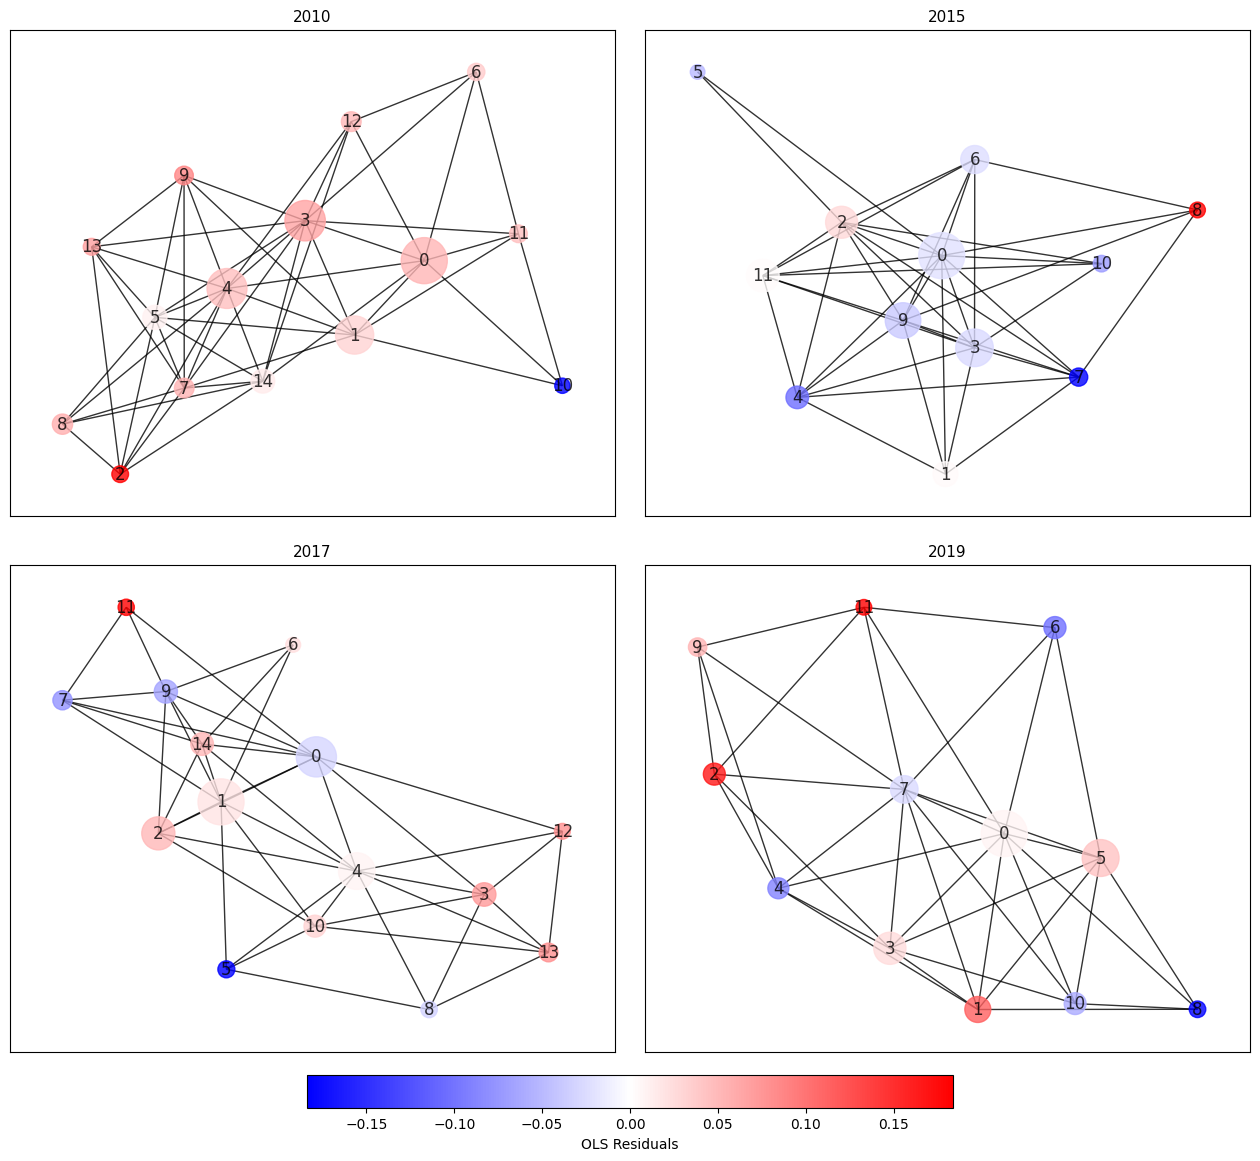

In [25]:
# 1. Use a diverging colourmap with better readability
cmap = plt.cm.bwr

# 2. Selected features (unchanged)
vars2 = [
    "vote_share_margin",
    "enp_votes",
    "total_spending",
    "c11Unemployed",
    "c11FulltimeStudent",
    "c11HouseOwned",
    "ethnic_fractionalization",
    "religious_fractionalization",
    "c11QualLevel4",
    "age_65_plus",
    "male"
]

# 3. Compute symmetric vmin and vmax
abs_max = np.max(np.abs(df['ols_residuals']))
vmin, vmax = -abs_max, abs_max
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 4. Set up figure
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

# 5. Loop through election years
for i, (year, group) in enumerate(df.groupby('election_year')):
    group = group.reset_index(drop=True)
    X = group[vars2]
    color_df = group[['ols_residuals']]
    eps_val = 50

    # Create BallMapper object
    bm = pbm.BallMapper(X=X, eps=eps_val, coloring_df=color_df)

    # Assign node colours using diverging cmap
    for node in bm.Graph.nodes:
        val = bm.Graph.nodes[node]['ols_residuals']
        if val is not None and not np.isnan(val):
            bm.Graph.nodes[node]['color'] = cmap(norm(val))
        else:
            bm.Graph.nodes[node]['color'] = "black"

    # Plot without internal colorbar
    plt.sca(axes[i])
    bm.draw_networkx(
        coloring_variable='ols_residuals',
        color_palette=cmap,
        colorbar=False,
        vmin=vmin,
        vmax=vmax,
        MIN_SCALE=100,
        MAX_SCALE=1000
    )
    axes[i].set_title(f"{year}", fontsize=11)

# 6. Shared horizontal colourbar (slim)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes,
    orientation='horizontal',
    fraction=0.03,
    pad=0.07
)
cbar.set_label("OLS Residuals")

# 7. Final layout and save
plt.subplots_adjust(bottom=0.15, hspace=0.1, wspace=0.05)
plt.savefig("/Users/alexander/Documents/GitHub/turnout-uk/figs/tda/selected_features_eps50_coolwarm.jpg", format="jpeg", dpi=600)
plt.show()


### 2. SEM for 2015

/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


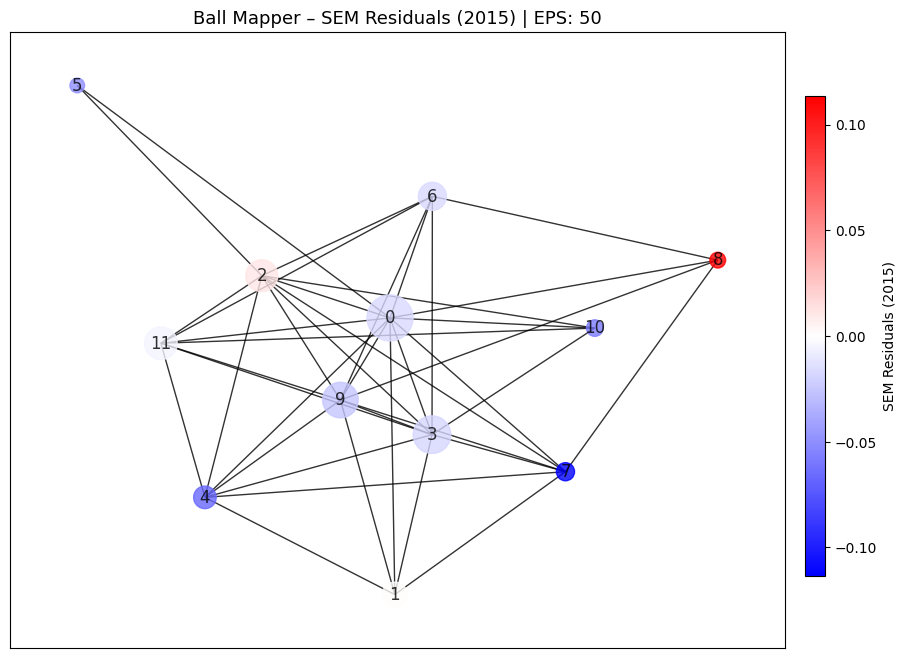

In [27]:
# 1. Filter only 2015
df_2015 = df[df['election_year'] == 2015].reset_index(drop=True)

# 2. Set predictor variables
vars2 = [
    "vote_share_margin",
    "enp_votes",
    "total_spending",
    "c11Unemployed",
    "c11FulltimeStudent",
    "c11HouseOwned",
    "ethnic_fractionalization",
    "religious_fractionalization",
    "c11QualLevel4",
    "age_65_plus",
    "male"
]

# 3. Set up BallMapper input
X = df_2015[vars2]
color_df = df_2015[['sem_2015_residuals']]

# 4. Symmetric diverging colour map (around 0)
abs_max = np.max(np.abs(color_df['sem_2015_residuals']))
vmin, vmax = -abs_max, abs_max
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.bwr  # <<< updated to bwr

# 5. Create BallMapper object
eps_val = 50
bm = pbm.BallMapper(X=X, eps=eps_val, coloring_df=color_df)

# 6. Assign node colours using diverging cmap
for node in bm.Graph.nodes:
    val = bm.Graph.nodes[node]['sem_2015_residuals']
    if val is not None and not np.isnan(val):
        bm.Graph.nodes[node]['color'] = cmap(norm(val))
    else:
        bm.Graph.nodes[node]['color'] = "black"

# 7. Plot Ball Mapper
fig, ax = plt.subplots(figsize=(10, 8))
plt.sca(ax)
bm.draw_networkx(
    coloring_variable='sem_2015_residuals',
    color_palette=cmap,
    colorbar=False,
    vmin=vmin,
    vmax=vmax,
    MIN_SCALE=100,
    MAX_SCALE=1000
)
ax.set_title("Ball Mapper – SEM Residuals (2015) | EPS: 50", fontsize=13)

# 8. Add vertical slim colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
cb = plt.colorbar(
    mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax
)
cb.set_label("SEM Residuals (2015)")

# 9. Final layout and save
plt.subplots_adjust(right=0.9)
plt.savefig("/Users/alexander/Documents/GitHub/turnout-uk/figs/tda/sem_2015_eps50_bwr.jpg", format="jpeg", dpi=600)
plt.show()


### Spatial Lag for Characteristic-based Distance Models

/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(
/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(
/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/si

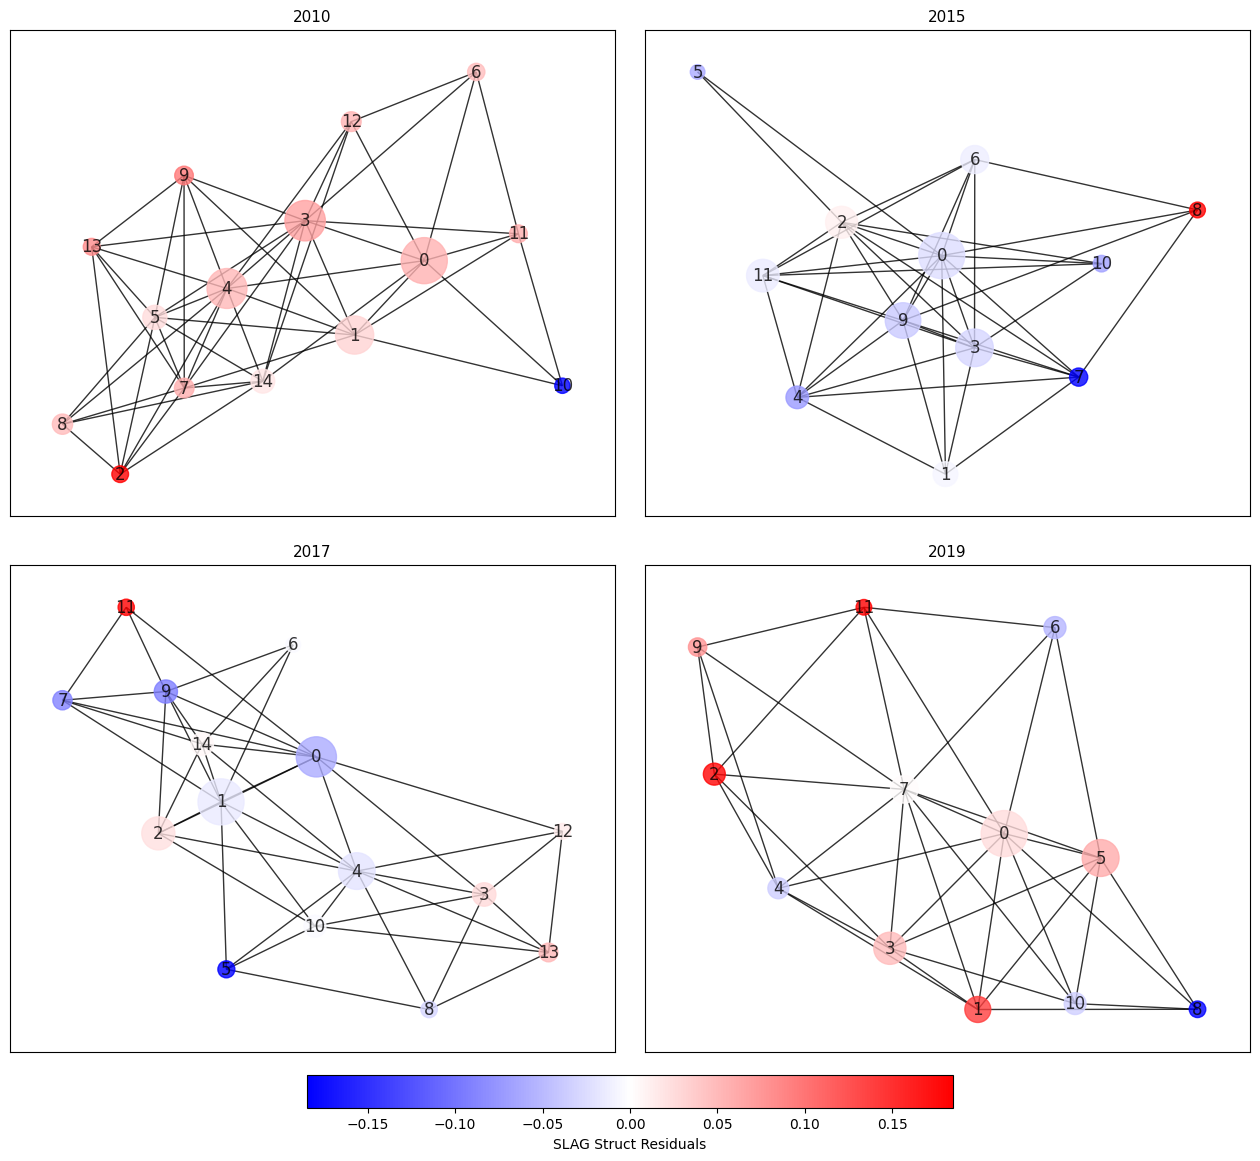

In [29]:
# 1. Use a diverging colourmap (light blue → white → red)
cmap = plt.cm.bwr

# 2. Predictor variables (unchanged)
vars2 = [
    "vote_share_margin",
    "enp_votes",
    "total_spending",
    "c11Unemployed",
    "c11FulltimeStudent",
    "c11HouseOwned",
    "ethnic_fractionalization",
    "religious_fractionalization",
    "c11QualLevel4",
    "age_65_plus",
    "male"
]

# 3. Compute symmetric vmin and vmax from all residuals
abs_max = np.max(np.abs(df['slag_struct_residuals']))
vmin, vmax = -abs_max, abs_max
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 4. Set up figure
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

# 5. Loop over years
for i, (year, group) in enumerate(df.groupby('election_year')):
    group = group.reset_index(drop=True)
    X = group[vars2]
    color_df = group[['slag_struct_residuals']]
    eps_val = 50

    # Create BallMapper object
    bm = pbm.BallMapper(X=X, eps=eps_val, coloring_df=color_df)

    # Assign node colours using symmetric diverging cmap
    for node in bm.Graph.nodes:
        val = bm.Graph.nodes[node]['slag_struct_residuals']
        if val is not None and not np.isnan(val):
            bm.Graph.nodes[node]['color'] = cmap(norm(val))
        else:
            bm.Graph.nodes[node]['color'] = "black"

    # Plot without internal colorbar
    plt.sca(axes[i])
    bm.draw_networkx(
        coloring_variable='slag_struct_residuals',
        color_palette=cmap,
        colorbar=False,
        vmin=vmin,
        vmax=vmax,
        MIN_SCALE=100,
        MAX_SCALE=1000
    )
    axes[i].set_title(f"{year}", fontsize=11)

# 6. Shared horizontal colourbar (slim)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes,
    orientation='horizontal',
    fraction=0.03,
    pad=0.07
)
cbar.set_label("SLAG Struct Residuals")

# 7. Final layout and save
plt.subplots_adjust(bottom=0.15, hspace=0.1, wspace=0.05)
plt.savefig("/Users/alexander/Documents/GitHub/turnout-uk/figs/tda/slag_struct_eps50_bwr.jpg", format="jpeg", dpi=600)
plt.show()
